# Real-Time Face Tracking

In this notebook, I have implemented Mediapipe Holistic, Google AI Edge BlazeFace Model, Haar Cascade Clasifier, YOLOv3 and Face Recognition module to compare and visualize image processing times for these various models.

There are three parts to using each model: 
1) Importing necessary modules and Initialization of global variables.
2) Computing average processing time over a series of 10 frames.
3) Live-Tracking for each of the models. (As if it works well on this, it would work better on a video)

## Install Necessary Packages

Installing requirements from the requirements.txt file

In [1]:
!pip install -r requirements.txt

## Check Cam Availability

In [2]:
import cv2
cap = cv2.VideoCapture(0) # Adjust the 0 value, according to your camera
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Webcam Live-Stream', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'): # Press 'q' on your keyboard to quit
        break

cap.release()
cv2.destroyAllWindows()

2024-06-17 11:22:51.327 python[66086:3349832] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


## Mediapipe Holistic Detections (Single Face)

In [1]:
import cv2
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import clear_output
import mediapipe as mp
import time
cap = cv2.VideoCapture(0)

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)


2024-06-17 11:23:47.718 python[66116:3350835] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1718603629.116472       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Average Processing Time

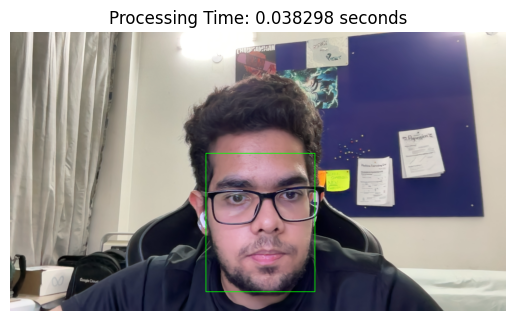

Processing Time: 0.038298 seconds
Average Processing Time (excluding first capture): 0.044733 seconds


In [2]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    try:
        processing_times = []
        capture_count = 0
        while cap.isOpened() and capture_count < 11:  # We want 11 captures, discard the first
            ret, frame = cap.read()
            if not ret:
                break

            start_time = time.perf_counter()

            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            results = holistic.process(image_rgb)
            
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

            # Draw face bounding box if landmarks are detected
            if results.face_landmarks:
                h, w, _ = image_rgb.shape
                face_landmarks = results.face_landmarks.landmark
                
                # Get bounding box coordinates
                x_min = min([lm.x for lm in face_landmarks]) * w
                x_max = max([lm.x for lm in face_landmarks]) * w
                y_min = min([lm.y for lm in face_landmarks]) * h
                y_max = max([lm.y for lm in face_landmarks]) * h
                
                cv2.rectangle(image_bgr, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

            end_time = time.perf_counter()
            processing_time = end_time - start_time
            
            if capture_count > 0:  # Discard the first capture as it usually takes more time.
                processing_times.append(processing_time)

            capture_count += 1

            # Display image
            image_rgbnew = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)  # Clear previous output
            plt.imshow(image_rgbnew)
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.title(f"Processing Time: {processing_time:.6f} seconds")
            plt.show()
            print(f"Processing Time: {processing_time:.6f} seconds")

            key = input("Press 'w' to save image as RGB PNG file (or any other key to continue): ")
            if key == 'w':
                plt.imsave('face_image_rgb.png', image_rgb)

        # Calculate and print average processing time
        if processing_times:
            average_processing_time = sum(processing_times) / len(processing_times)
            print(f"Average Processing Time (excluding first capture): {average_processing_time:.6f} seconds")
    
    finally:
        cap.release()

### Live Face-Tracking

In [2]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            results = holistic.process(image)
            
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            if results.face_landmarks:
                h, w, _ = image.shape
                face_landmarks = results.face_landmarks.landmark
                
                # Get bounding box coordinates
                x_min = min([lm.x for lm in face_landmarks]) * w
                x_max = max([lm.x for lm in face_landmarks]) * w
                y_min = min([lm.y for lm in face_landmarks]) * h
                y_max = max([lm.y for lm in face_landmarks]) * h
                
                # Draw bounding box on image
                cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            
            cv2.imshow('Live Face-Tracking', image)
            
            key = cv2.waitKey(10)
            
            # Exit loop if 'q' is pressed
            if key & 0xFF == ord('q'):
                break
    
    finally:
        cap.release()
        cv2.destroyAllWindows()

I0000 00:00:1718603629.218054       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2 Pro


## Google AI Edge BlazeFace

In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
model_path = 'weights/blaze_face_short_range.tflite'

### BlazeFace (short-range)
A lightweight model for detecting single or multiple faces within selfie-like images from a smartphone camera or webcam. The model is optimized for front-facing phone camera images at short range. The model architecture uses a Single Shot Detector (SSD) convolutional network technique with a custom encoder.

In [1]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
FaceDetectorResult = mp.tasks.vision.FaceDetectorResult
VisionRunningMode = mp.tasks.vision.RunningMode

### Average Processing Time

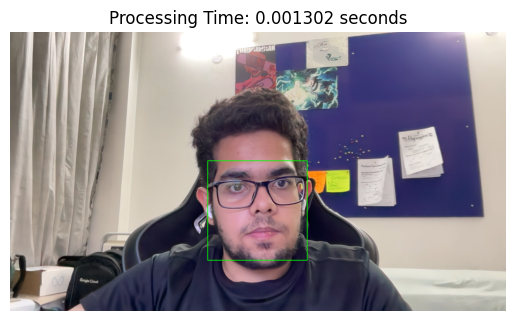

Processing Time: 0.001302 seconds
Average Processing Time (excluding first capture): 0.001590 seconds


In [3]:
latest_result = None

def detect_faces_in_live_stream():
    def print_result(result: FaceDetectorResult, output_image: mp.Image, timestamp_ms: int):
        global latest_result
        latest_result = result
        #print('Face detection result at {}ms: {}'.format(timestamp_ms, result))

    options = FaceDetectorOptions(
        base_options=BaseOptions(model_asset_path='weights/blaze_face_short_range.tflite'),
        running_mode=VisionRunningMode.LIVE_STREAM,
        min_detection_confidence=0.5,
        min_suppression_threshold=0.3,
        result_callback=print_result
    )

    with FaceDetector.create_from_options(options) as detector:
        cap = cv2.VideoCapture(0)  # Open the default webcam
        start_time = time.time()
        processing_times = []
        capture_count = 0

        while cap.isOpened() and capture_count < 11:  # We want 11 captures, discard the first
            ret, frame = cap.read()
            if not ret:
                break

            frame_start_time = time.perf_counter()

            timestamp_ms = int((time.time() - start_time) * 1000)
            
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            
            detector.detect_async(mp_image, timestamp_ms)

            if latest_result:
                for detection in latest_result.detections:
                    bbox = detection.bounding_box
                    start_point = (int(bbox.origin_x), int(bbox.origin_y))
                    end_point = (int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height))
                    color = (0, 255, 0)
                    thickness = 2
                    cv2.rectangle(frame, start_point, end_point, color, thickness)

            frame_end_time = time.perf_counter()
            processing_time = frame_end_time - frame_start_time
            
            if capture_count > 0:  # Discard the first capture as it usually takes more time.
                processing_times.append(processing_time)

            capture_count += 1

            # Display image using Matplotlib
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)  # Clear previous output
            plt.imshow(image_rgb)
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.title(f"Processing Time: {processing_time:.6f} seconds")
            plt.show()
            print(f"Processing Time: {processing_time:.6f} seconds")

            # Break loop on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Calculate and print average processing time
        if processing_times:
            average_processing_time = sum(processing_times) / len(processing_times)
            print(f"Average Processing Time (excluding first capture): {average_processing_time:.6f} seconds")
    
        cap.release()
        cv2.destroyAllWindows()

# Example usage
detect_faces_in_live_stream()


### Live Face-Tracking

In [2]:
# Global variable to hold the latest result
latest_result = None

def detect_faces_in_live_stream():
    def print_result(result: FaceDetectorResult, output_image: mp.Image, timestamp_ms: int):
        global latest_result
        latest_result = result
        #print('Face detection result at {}ms: {}'.format(timestamp_ms, result))

    options = FaceDetectorOptions(
        base_options=BaseOptions(model_asset_path='weights/blaze_face_short_range.tflite'),
        running_mode=VisionRunningMode.LIVE_STREAM,
        min_detection_confidence=0.5,
        min_suppression_threshold=0.3,
        result_callback=print_result
    )

    with FaceDetector.create_from_options(options) as detector:
        cap = cv2.VideoCapture(0)  # Open the default webcam
        start_time = time.time()

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            timestamp_ms = int((time.time() - start_time) * 1000)
            
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            
            detector.detect_async(mp_image, timestamp_ms)

            if latest_result:
                for detection in latest_result.detections:
                    bbox = detection.bounding_box
                    start_point = (int(bbox.origin_x), int(bbox.origin_y))
                    end_point = (int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height))
                    color = (0, 255, 0)  # Green color for the bounding box
                    thickness = 2
                    cv2.rectangle(frame, start_point, end_point, color, thickness)

            # Display the frame
            cv2.imshow('Face Detection', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# Example usage
detect_faces_in_live_stream()

I0000 00:00:1718603723.010751       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-06-17 11:25:23.227 python[66152:3352013] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


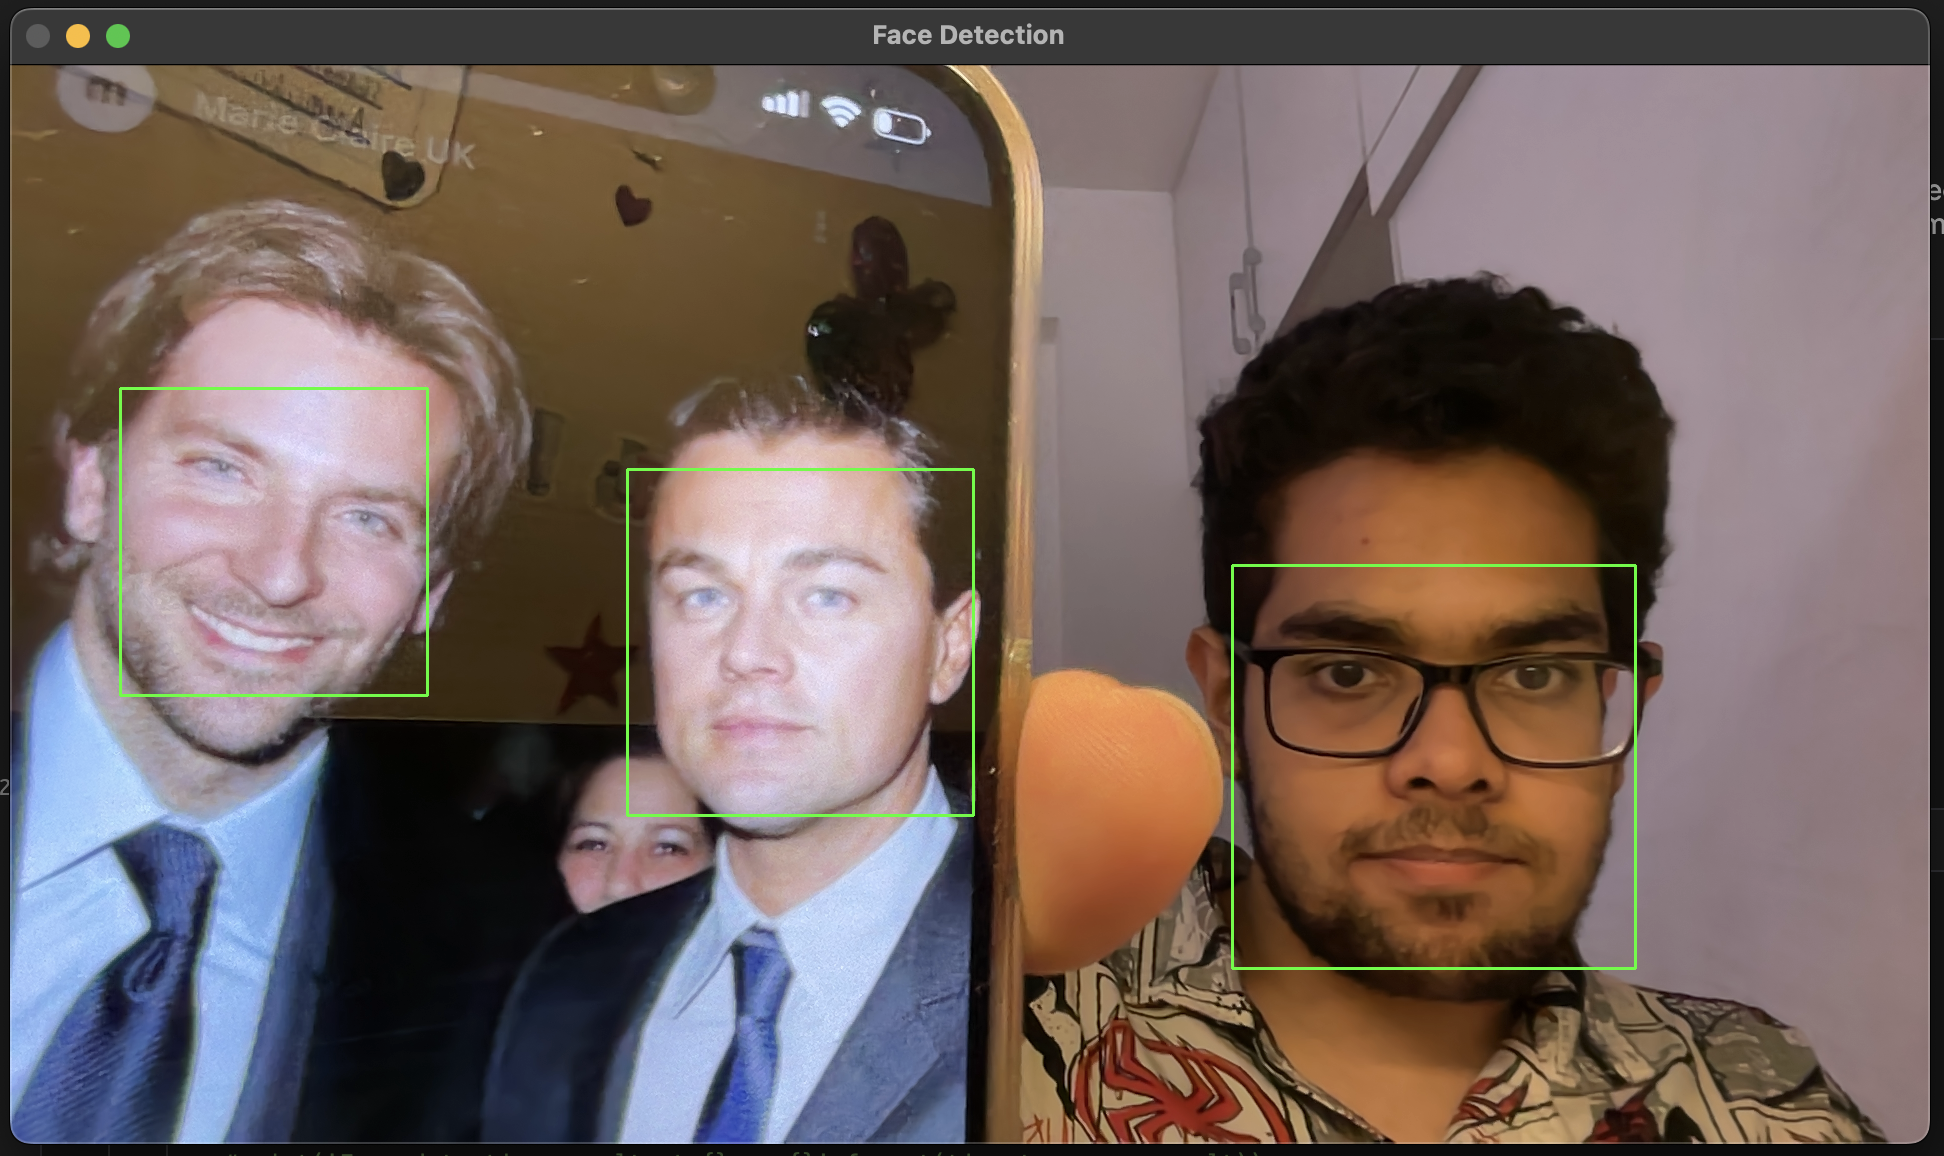

This was a bit laggy and as stated before worked only for short range. Like people in a selfie-distance.

## Haar Cascade Classfier (Multi Face Detection)

In [1]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Load the Haar Cascade face classifier
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

### Average Processing Time (Haar Cascade)

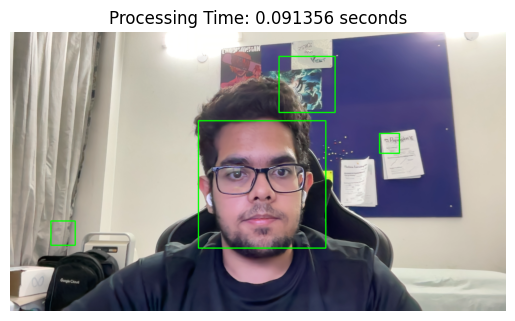

Processing Time: 0.091356 seconds
Average Processing Time (excluding first capture): 0.138297 seconds


In [2]:
def detect_faces_in_live_stream():
    cap = cv2.VideoCapture(0)  # Open the default webcam
    processing_times = []
    capture_count = 0

    while cap.isOpened() and capture_count < 11:  # We want 11 captures, discard the first
        ret, frame = cap.read()
        if not ret:
            break

        frame_start_time = time.perf_counter()

        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_classifier.detectMultiScale(
            gray_image, scaleFactor=1.05, minNeighbors=7, minSize=(40, 40)
        )
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)

        frame_end_time = time.perf_counter()
        processing_time = frame_end_time - frame_start_time
        
        if capture_count > 0:  # Discard the first capture
            processing_times.append(processing_time)

        capture_count += 1

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)  # Clear previous output
        plt.imshow(image_rgb)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title(f"Processing Time: {processing_time:.6f} seconds")
        plt.show()
        print(f"Processing Time: {processing_time:.6f} seconds")

        # Break loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Calculate and print average processing time
    if processing_times:
        average_processing_time = sum(processing_times) / len(processing_times)
        print(f"Average Processing Time (excluding first capture): {average_processing_time:.6f} seconds")

    cap.release()
    cv2.destroyAllWindows()

detect_faces_in_live_stream()

### Live Face-Tracking (Haar Cascade)

In [ ]:
import cv2
import matplotlib.pyplot as plt

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_faces_in_live_stream():
    cap = cv2.VideoCapture(0)  # Open the default webcam
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_classifier.detectMultiScale(
            gray_image, scaleFactor=1.05, minNeighbors=7, minSize=(40, 40)
        )
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)
        
        cv2.imshow('Live Face Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Run the live stream face detection
detect_faces_in_live_stream()


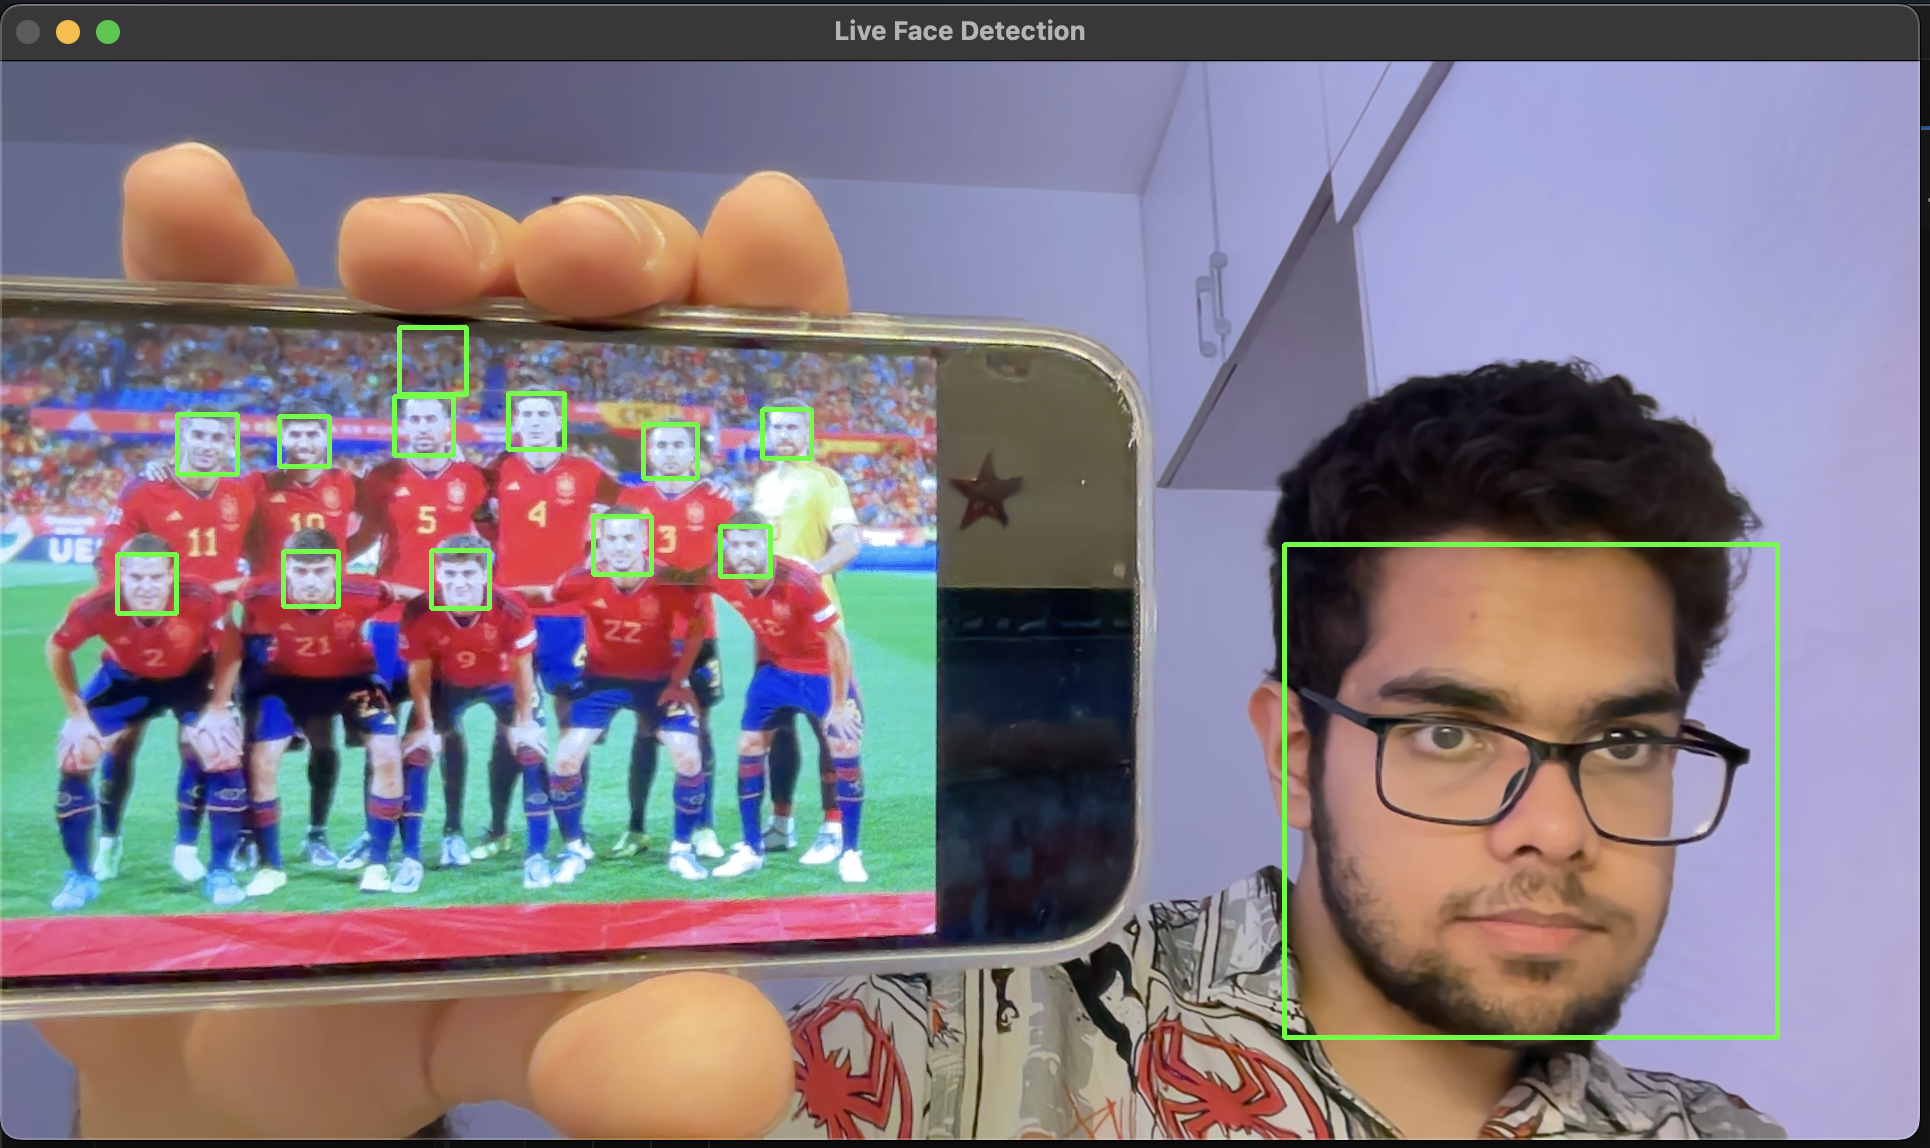

This worked surprising well! And was able to give almost perfect bounding boxes for the images, even in a football team picture!

## MTCNN (Multi Face Detection)

In [1]:
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from IPython.display import clear_output
import time

detector = MTCNN()
cap = cv2.VideoCapture(0)

2024-06-17 11:27:26.367 python[66211:3353918] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


### Average Processing Time (MTCNN)

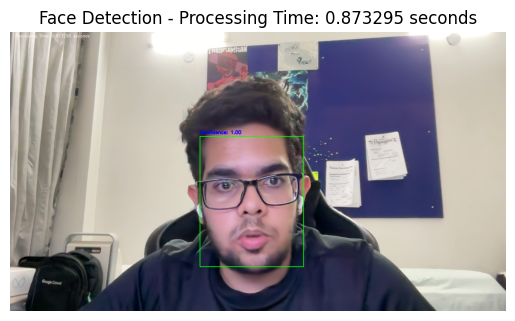

Average Processing Time (excluding first capture): 0.897686 seconds


In [2]:
processing_times = []
capture_count = 0

while capture_count < 11:  # We want 11 captures, excluding the first one
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.perf_counter()

    faces = detector.detect_faces(frame)

    for face in faces:
        x, y, width, height = face['box']
        cv2.rectangle(frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
        cv2.putText(frame, f"Confidence: {face['confidence']:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    end_time = time.perf_counter()
    processing_time = end_time - start_time

    if capture_count > 0:  # Skip the first capture
        processing_times.append(processing_time)

    capture_count += 1

    cv2.putText(frame, f"Processing Time: {processing_time:.6f} seconds", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Convert frame from BGR to RGB for matplotlib display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display using matplotlib
    clear_output(wait=True)  # Clear previous output
    plt.clf()
    plt.imshow(frame_rgb)
    plt.title(f'Face Detection - Processing Time: {processing_time:.6f} seconds')
    plt.axis('off')
    plt.pause(0.001)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Calculate and print average processing time
if processing_times:
    average_processing_time = sum(processing_times) / len(processing_times)
    print(f"Average Processing Time (excluding first capture): {average_processing_time:.6f} seconds")

cap.release()
cv2.destroyAllWindows()

### Live Face-Tracking (MTCNN)

In [ ]:
import cv2
from mtcnn import MTCNN

detector = MTCNN()
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    faces = detector.detect_faces(frame)

    for face in faces:
        x, y, width, height = face['box']
        cv2.rectangle(frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
        cv2.putText(frame, f"Confidence: {face['confidence']:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    cv2.imshow('Face Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# Codes below are currently not working

# YuNet

In [ ]:
import os
import numpy as np
import cv2

def detect_faces_with_yunet():
    capture = cv2.VideoCapture(0)  # Accessing the camera
    if not capture.isOpened():
        exit()
    
    weights_path = os.path.join("weights/face_detection_yunet_2022mar.onnx")
    net = cv2.dnn.readNetFromONNX(weights_path)
    
    while True:
        result, image = capture.read()
        if result is False:
            cv2.waitKey(0)
            break

        channels = 1 if len(image.shape) == 2 else image.shape[2]
        if channels == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if channels == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        height, width, _ = image.shape
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)

        net.setInput(blob)
        detections = net.forward()
        print(detections)
        for i in range(detections.shape[0]):
            confidence = detections[i]
            if confidence > 0.5:
                box = detections[i, 3:7] * np.array([width, height, width, height])
                (startX, startY, endX, endY) = box.astype("int")

                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

                text = "{:.2f}%".format(confidence * 100)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

        cv2.imshow("face detection", image)
        key = cv2.waitKey(10)
        if key == ord('q'):
            break
    
    capture.release()
    cv2.destroyAllWindows()

detect_faces_with_yunet()

# YOLOv3-face Face Detection (some errors to debug)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

# Load YOLOv3 model and weights for face detection
modelConfiguration = "weights/yolov3-face.cfg"
modelWeights = "weights/yolov3-wider_16000.weights"
 
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
def detect_faces_with_yolo(frame):
    height, width, channels = frame.shape

    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    faces = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # 0 corresponds to the 'face' class in YOLOv3
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))

    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)
        faces.append(frame[y:y + h, x:x + w])

    return frame

def detect_faces_in_live_stream():
    cap = cv2.VideoCapture(0)  # Open the default webcam
    processing_times = []
    capture_count = 0

    while cap.isOpened() and capture_count < 11:  # We want 11 captures, discard the first
        ret, frame = cap.read()
        if not ret:
            break

        # Record the start time for this frame
        frame_start_time = time.perf_counter()

        # Perform face detection using YOLO
        frame = detect_faces_with_yolo(frame)

        # Calculate processing time for this frame
        frame_end_time = time.perf_counter()
        processing_time = frame_end_time - frame_start_time
        
        if capture_count > 0:  # Discard the first capture
            processing_times.append(processing_time)

        capture_count += 1

        # Display image using Matplotlib
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)  # Clear previous output
        plt.imshow(image_rgb)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title(f"Processing Time: {processing_time:.6f} seconds")
        plt.show()
        print(f"Processing Time: {processing_time:.6f} seconds")

        # Break loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Calculate and print average processing time
    if processing_times:
        average_processing_time = sum(processing_times) / len(processing_times)
        print(f"Average Processing Time (excluding first capture): {average_processing_time:.6f} seconds")

    cap.release()
    cv2.destroyAllWindows()

# Run the live stream face detection with YOLO
detect_faces_in_live_stream()

# Face Recognition
By comparing face encodings using the face recognition library, it should be able to recognize faces even from a single example image. (This code is not working currently)

In [ ]:
import face_recognition
import cv2
import numpy as np

video_capture = cv2.VideoCapture(0)

vish_image = face_recognition.load_image_file("pictures/vishgpic.png")
vish_face_encoding = face_recognition.face_encodings(vish_image)[0]

elon_image = face_recognition.load_image_file("pictures/elonmusk.jpg")
elon_face_encoding = face_recognition.face_encodings(elon_image)[0]


known_face_encodings = [
    vish_face_encoding,
    elon_face_encoding
]
known_face_names = [
    "Vishrut",
    "Elon Musk"
]

In [ ]:
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

while True:
    ret, frame = video_capture.read()

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

    rgb_small_frame = small_frame[:, :, ::-1]

    if process_this_frame:
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

    process_this_frame = not process_this_frame


    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()